# 第 3 章 词中的数学

  我们已经收集了一些词（词条），对这些词进行了计数，并将它们归并成词干或者词元，从而得到了词用法的一些简单统计信息，也能据此进行关键词检索。但是我们更想知道哪些词对于某篇具体文档和整个语料库更重要，进一步我们可以利用这个“重要度”值在语料库中寻找相关文档。　　　　　　　　　　　　　　
    这样做的话，在实际应用中，可以提升垃圾邮件过滤器、推文情感度量器的精确度。

本章将介绍以下２种表示能力逐步增强的对词及其在文档中的重要度进行表示的方法：  
 利用词出现频率或词频向量；    
 TF-IDF 向量——更好地表示词的重要度。  
    
    词项频率TF:每个词在某篇文档中的出现次数除以文档中的词项总数。  
    逆文档频率IDF:文档集合中的文档总数除以某个词出现的文档数。
    TF-IDF ：词项频率（term frequency）乘以逆文档频率（inverse document frequency）。

## 词袋

引入假设：一个词在文档中出现的次数越多，那么该词对文档的意义的贡献就越大。  
如：  
相比于多次提到“cats”和“gravity”的文档，一篇多次提到“wings”和“rudder”的文档可能会与喷气式飞机或者航空旅行的主题更相关。  
一篇文档包含的表达正向情感的词，如 good、best、joy 和 fantastic越多，就认为它越可能包含了正向情感。

一个有用的向量表示方法：计算词在给定文本中的出现次数或者频率。  

In [248]:
#词袋向量/词频向量
>>> sentences = """Thomas Jefferson began building Monticello at the age of 26.\n""" 
>>> sentences += """Construction was done mostly by local masons and carpenters.\n""" 
>>> sentences += "He moved into the South Pavilion in 1770.\n" 
>>> sentences += """Turning Monticello into a neoclassical masterpiece was Jefferson's obsession.""" 
>>> corpus = {} 
>>> for i, sent in enumerate(sentences.split('\n')): 
     corpus['sent{}'.format(i)] = dict((tok, 1) for tok in sent.split()) 
>>> df = pd.DataFrame.from_records(corpus).fillna(0).astype(int).T 
>>> df[df.columns]

,Thomas,Jefferson,began,building,Monticello,at,the,age,of,26.,...,South,Pavilion,in,1770.,Turning,a,neoclassical,masterpiece,Jefferson's,obsession.
sent0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
sent1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sent2,0,0,0,0,0,0,1,0,0,0,...,1,1,1,1,0,0,0,0,0,0
sent3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1


In [251]:
#分词
>>> from nltk.tokenize import TreebankWordTokenizer 
>>> sentence = """The faster Harry got to the store, the faster Harry, the faster, would get home.""" 
>>> tokenizer = TreebankWordTokenizer() 
>>> tokens = tokenizer.tokenize(sentence.lower()) 
>>> print(tokens)

['the', 'faster', 'harry', 'got', 'to', 'the', 'store', ',', 'the', 'faster', 'harry', ',', 'the', 'faster', ',', 'would', 'get', 'home', '.']


In [252]:
#计算每个词出现的次数
>>> from collections import Counter 
>>> bag_of_words = Counter(tokens) #Counter 会以某种看似合理的次序来显示，但对于标准的 Python dict，我们不能依赖词条在 Counter 中的次序
>>> bag_of_words

Counter({'the': 4,
         'faster': 3,
         'harry': 2,
         'got': 1,
         'to': 1,
         'store': 1,
         ',': 3,
         'would': 1,
         'get': 1,
         'home': 1,
         '.': 1})

上面短文档的无序词袋仍然包含了句子的原本意图中的很多信息。这些词袋中的信息对于部分任务已经足够充足，这些任务包括垃圾邮件检测、情感（包括倾向性、满意度等）计算，甚至一些微妙意图的检测如讽刺检测。  
下面我们将这些词按照某种方式进行排序，以便能够对此进一步了解。

In [158]:
>>> bag_of_words.most_common(4) #在默认情况下，most_common()会按照频率从高到低列出所有的词条，这里只给出频率最高的4个词条

[('the', 4), ('faster', 3), (',', 3), ('harry', 2)]

考虑词“dog”在文档 A 中出现 3 次，在文档 B 中出现 100 次。显然，“dog”似乎对文档 B 更重要，但是等等！这里的文档 A 只是一封写给兽医的 30 个词的电子邮件，而文档 B 却是包含大约 580 000 个词的长篇巨著《战争与和平》（War & Peace）！因此，我们一开始的分析结果应该正好反过来，即“dog”对文档 A 更重要。　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
归一化词项频率TF：将某个词的出现次数除以文档中的词项总数从而得到的结果，是经过文档长度“调和”后的词频。  

In [159]:
>>> times_harry_appears = bag_of_words['harry'] #以harry为例
>>> num_unique_words = len(bag_of_words) 
>>> tf = times_harry_appears / num_unique_words 
>>> round(tf, 4)

0.1818

下面考虑一个更长的文本片段，它来自维基百科中有关风筝（kite）的文章的前几个段落。

   A kite is traditionally a tethered heavier-than-air craft with wing surfaces that react 
against the air to create lift and drag. A kite consists of wings, tethers, and anchors. Kites 
often have a bridle to guide the face of the kite at the correct angle so the wind can lift it. A 
kite’s wing also may be so designed so a bridle is not needed; when kiting a sailplane for 
launch, the tether meets the wing at a single point. A kite may have fixed or moving anchors. 
Untraditionally in technical kiting, a kite consists of tether-set-coupled wing sets; even in 
technical kiting, though, a wing in the system is still often called the kite.The lift that sustains the kite in flight is generated when air flows around the kite’s 
surface, producing low pressure above and high pressure below the wings. The interaction 
with the wind also generates horizontal drag along the direction of the wind. The resultant 
force vector from the lift and drag force components is opposed by the tension of one or more 
of the lines or tethers to which the kite is attached. The anchor point of the kite line may be 
static or moving (such as the towing of a kite by a running person, boat, free-falling anchors 
as in paragliders and fugitive parakites or vehicle). 
The same principles of fluid flow apply in liquids and kites are also used under water. 
A hybrid tethered craft comprising both a lighter-than-air balloon as well as a kite lifting 
surface is called a kytoon. 
Kites have a long and varied history and many different types are flown individually and 
at festivals worldwide. Kites may be flown for recreation, art or other practical uses. Sport 
kites can be flown in aerial ballet, sometimes as part of a competition. Power kites are 
multi-line steerable kites designed to generate large forces which can be used to power 
activities such as kite surfing, kite landboarding, kite fishing, kite buggying and a new trend 
snow kiting. Even Man-lifting kites have been made.

In [160]:
from collections import Counter 
from nltk.tokenize import TreebankWordTokenizer 
tokenizer = TreebankWordTokenizer() 
import pandas
import nltk
from nlpia.data.loaders import kite_text 
tokens = tokenizer.tokenize(kite_text.lower()) 
token_counts = Counter(tokens) 
token_counts

Counter({'a': 20,
         'kite': 16,
         'is': 7,
         'traditionally': 1,
         'tethered': 2,
         'heavier-than-air': 1,
         'craft': 2,
         'with': 2,
         'wing': 5,
         'surfaces': 1,
         'that': 2,
         'react': 1,
         'against': 1,
         'the': 26,
         'air': 2,
         'to': 5,
         'create': 1,
         'lift': 4,
         'and': 10,
         'drag.': 1,
         'consists': 2,
         'of': 10,
         'wings': 1,
         ',': 15,
         'tethers': 2,
         'anchors.': 2,
         'kites': 8,
         'often': 2,
         'have': 4,
         'bridle': 2,
         'guide': 1,
         'face': 1,
         'at': 3,
         'correct': 1,
         'angle': 1,
         'so': 3,
         'wind': 2,
         'can': 3,
         'it.': 1,
         "'s": 2,
         'also': 3,
         'may': 4,
         'be': 5,
         'designed': 2,
         'not': 1,
         'needed': 1,
         ';': 2,
         'when': 2,


In [161]:
#去除“the”“a”、连词“and”以及其他停用词
>>> import nltk 
>>> nltk.download('stopwords', quiet=True) 
>>> stopwords = nltk.corpus.stopwords.words('english')
>>> tokens = [x for x in tokens if x not in stopwords] 
>>> kite_counts = Counter(tokens) 
>>> kite_counts

[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


Counter({'kite': 16,
         'traditionally': 1,
         'tethered': 2,
         'heavier-than-air': 1,
         'craft': 2,
         'wing': 5,
         'surfaces': 1,
         'react': 1,
         'air': 2,
         'create': 1,
         'lift': 4,
         'drag.': 1,
         'consists': 2,
         'wings': 1,
         ',': 15,
         'tethers': 2,
         'anchors.': 2,
         'kites': 8,
         'often': 2,
         'bridle': 2,
         'guide': 1,
         'face': 1,
         'correct': 1,
         'angle': 1,
         'wind': 2,
         'it.': 1,
         "'s": 2,
         'also': 3,
         'may': 4,
         'designed': 2,
         'needed': 1,
         ';': 2,
         'kiting': 3,
         'sailplane': 1,
         'launch': 1,
         'tether': 1,
         'meets': 1,
         'single': 1,
         'point.': 1,
         'fixed': 1,
         'moving': 2,
         'untraditionally': 1,
         'technical': 2,
         'tether-set-coupled': 1,
         'sets': 1,

单纯凭借词在文档中出现的次数：词项 kite(s)、wing 和 lift都很重要。并且，如果我们不知道这篇文章的主题是什么，只是碰巧在大规模的类谷歌知识库中浏览到这篇文章，那么我们可能“程序化”地推断出，这篇文章与“flight”或者“lift”相关，或者实际上和“kite”相关。

## 向量化

我们已经将文本转换为基本的数值。虽然仍然只是把它们存储在字典中。  
接下来我们不使用频率字典，而是构建词频向量来描述文档，对于这种向量，我们可以直接对它们进行数学运算。

In [162]:
>>> document_vector = [] 
>>> doc_length = len(tokens) 
>>> for key, value in kite_counts.most_common(): document_vector.append(value / doc_length) 
>>> document_vector

[0.07207207207207207,
 0.06756756756756757,
 0.036036036036036036,
 0.02252252252252252,
 0.018018018018018018,
 0.018018018018018018,
 0.013513513513513514,
 0.013513513513513514,
 0.013513513513513514,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.

只有一篇文档对应一个向量是不够的，我们需要获取更多的文档，并为每篇文档创建其对应的向量。由于每个向量内部的值必须要相对于某个在所有向量上的一致性结果进行计算，所以在每个维度上都有相同的表示尺度（scale）或者“单位”。  
1.计算归一化词项频率，而不是原始词频；  
2.将所有向量都转换到标准长度或维度上去。  
3.使得每个文档向量同一维上的元素值代表同一个词  
我们会在每篇文档中找到独立的词，然后将这些词集合求并集后从中找到每个独立的词，组合成词库（lexicon）。

In [163]:
#一个包含 3 篇文档的语料库
>>> docs = ["The faster Harry got to the store, the faster and faster Harry would get home."] 
>>> docs.append("Harry is hairy and faster than Jill.") 
>>> docs.append("Jill is not as hairy as Harry.")
>>> docs

['The faster Harry got to the store, the faster and faster Harry would get home.',
 'Harry is hairy and faster than Jill.',
 'Jill is not as hairy as Harry.']

In [164]:
>>> doc_tokens = [] 
>>> for doc in docs: doc_tokens += [sorted(tokenizer.tokenize(doc.lower()))] 
>>> print(len(doc_tokens[0]))  #第一句话单词频数
>>> all_doc_tokens = sum(doc_tokens, [])  
>>> print(len(all_doc_tokens)) #三句话单词总频数
>>> lexicon = sorted(set(all_doc_tokens))  #三句话所有不重复单词
>>> print(len(lexicon) ) #三句话不重复单词数
>>> lexicon

17
33
18


[',',
 '.',
 'and',
 'as',
 'faster',
 'get',
 'got',
 'hairy',
 'harry',
 'home',
 'is',
 'jill',
 'not',
 'store',
 'than',
 'the',
 'to',
 'would']

尽管有些文档并不包含词库中所有的18个词，但是上面3篇文档的每个文档向量都包含18个值。即每个词条都会被分配向量中的一个槽位（slot），对应的是它在词库中的位置。

In [165]:
#全为0的基本向量
>>> from collections import OrderedDict 
>>> zero_vector = OrderedDict((token, 0) for token in lexicon) 
>>> zero_vector

OrderedDict([(',', 0),
             ('.', 0),
             ('and', 0),
             ('as', 0),
             ('faster', 0),
             ('get', 0),
             ('got', 0),
             ('hairy', 0),
             ('harry', 0),
             ('home', 0),
             ('is', 0),
             ('jill', 0),
             ('not', 0),
             ('store', 0),
             ('than', 0),
             ('the', 0),
             ('to', 0),
             ('would', 0)])

In [166]:
>>> import copy 
>>> doc_vectors = [] 
>>> for doc in docs: 
    vec = copy.copy(zero_vector) 
    tokens = tokenizer.tokenize(doc.lower()) 
    token_counts = Counter(tokens) 
    for key, value in token_counts.items():
        vec[key] = value / len(lexicon) 
    doc_vectors.append(vec)
>>> doc_vectors

[OrderedDict([(',', 0.05555555555555555),
              ('.', 0.05555555555555555),
              ('and', 0.05555555555555555),
              ('as', 0),
              ('faster', 0.16666666666666666),
              ('get', 0.05555555555555555),
              ('got', 0.05555555555555555),
              ('hairy', 0),
              ('harry', 0.1111111111111111),
              ('home', 0.05555555555555555),
              ('is', 0),
              ('jill', 0),
              ('not', 0),
              ('store', 0.05555555555555555),
              ('than', 0),
              ('the', 0.16666666666666666),
              ('to', 0.05555555555555555),
              ('would', 0.05555555555555555)]),
 OrderedDict([(',', 0),
              ('.', 0.05555555555555555),
              ('and', 0.05555555555555555),
              ('as', 0),
              ('faster', 0.05555555555555555),
              ('get', 0),
              ('got', 0),
              ('hairy', 0.05555555555555555),
              ('harry', 0.05

### 向量空间

向量：一个有序的数值列表，或者说这些数值是向量空间中的坐标。它描述了空间中的一个位置，或者也可用来确定空间中一个特定的方向和大小或距离。   
空间（space）是所有可能出现在这个空间中的向量的集合。  
两个值组成的向量在二维向量空间中，而3个值组成的向量在三维向量空间中，以此类推可以有5维、10维、5000维等各种维度的空间。

对于自然语言文档向量空间，向量空间的维数是整个语料库中出现的不同词的数量，有时会用一个大写字母K来表示维数，称它为K维空间。在前面3篇关于 Harry 和 Jill 的文档语料库中，K = 18。然后可以用这个K维空间中的一个K维向量来描述每篇文档。

可视化举例：
18维 Harry 和 Jill 文档向量空间的二维视图，此时K被简化为 2。

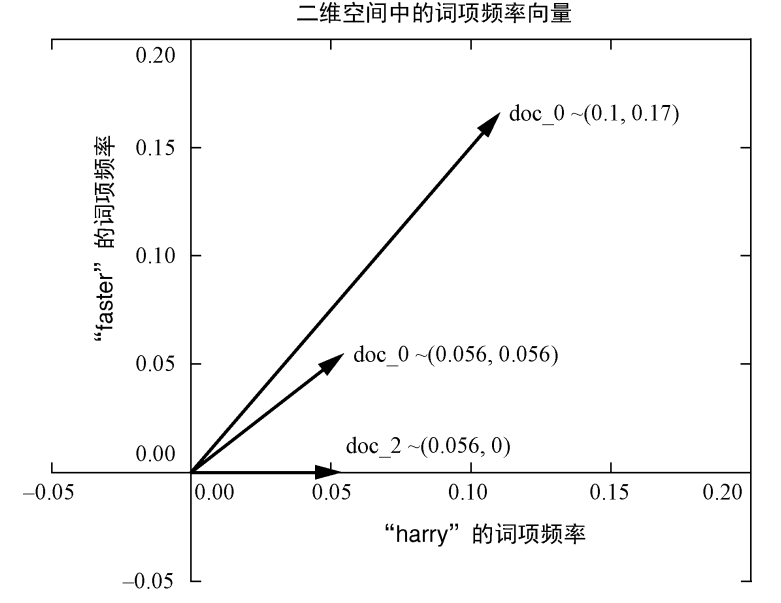


### 相似度

每个文档的表示形式（向量），共享公共空间（向量空间），接下来可以对它们的相似度进行比较。

1.欧几里得距离：向量相减，然后计算结果向量的大小，也称为2范数距离。  
缺点：数据维度越大，作用越小。

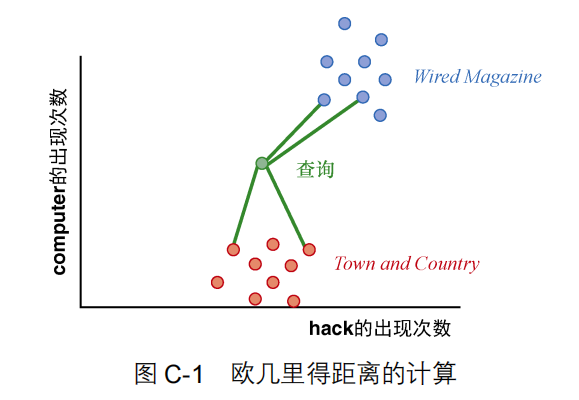

2.余弦相似度：两个向量夹角的余弦值，可以用欧几里得点积来计算：cosΘ=(A·B)/(|A|·|B|) ，给出的是两个向量指向同一方向的程度。   
原理：当对文档中词的向量表示进行相似度估算时，可以不关心文档长度，而只关心相同词的使用比例是否相似。故如果两个向量的方向相似，它们就“相似”。它们可能具有相似的大小（文档长度），但是也可能长度不同。  
优点：可以抵消欧几里得距离的高维度问题；不需要任何对三角函数求值，所以计算很高效；余弦相似度的取值范围（−1到+1）十分便于处理大多数机器学习问题。  
缺点：不考虑向量的大小，只考虑其方向。

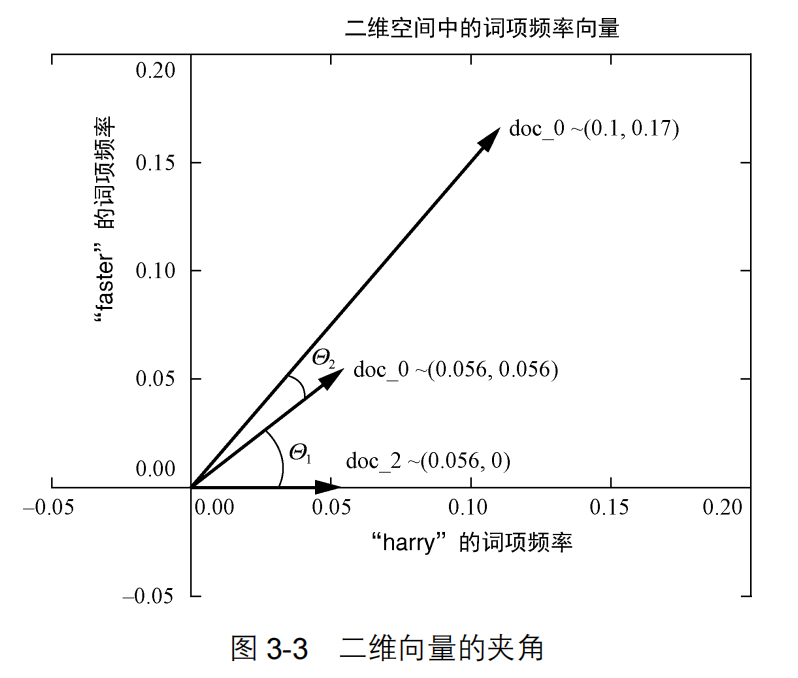


In [214]:
import math 
#余弦相似度计算函数
def cosine_sim(vec1, vec2): 
    """ Let's convert our dictionaries to lists for easier matching.""" 
    vec1 = [val for val in vec1.values()] 
    vec2 = [val for val in vec2.values()] 
    dot_prod = 0 
    for i, v in enumerate(vec1):
        dot_prod += v * vec2[i]  #A·B
    mag_1 = math.sqrt(sum([x**2 for x in vec1])) #|A|
    mag_2 = math.sqrt(sum([x**2 for x in vec2]))  #|B|
    return dot_prod / (mag_1 * mag_2) #cosΘ=(A·B)/(|A|·|B|)
a = {'a':3,'b':4}
b = {'a':12,'b':16}
cosine_sim(a, b)

1.0

余弦相似度=1：两个归一化向量完全相同，它们的长度或大小可能不一样，但在所有维度上都指向完全相同的方向。  
余弦相似度接近于1的NLP文档向量，应该使用了比例相近的相似词，因此很可能涉及同一主题。

余弦相似度=0：表示两个向量之间没有任何共享分量，它们在所有维度上都互相垂直。  
对于 NLP 中的词频向量，只有当两篇文档没有公共词时才会出现这种情况。说明这些文档使用完全不同的词，但这并不意味着它们一定就有不同的含义或主题。

余弦相似度=−1：表示两个向量是反相似（anti-similar）的，即完全相反，也就是两个向量指向完全相反的方向。对于简单的词频向量，甚至是归一化的词频（词项频率）向量（我们稍后将讨论），都不可能会发生这种情况。因为词的数目永远不会是负数，所以词频向量总是处于向量空间的同一象限中，一个分量不可能与另一个词项频率向量分量的符号相反。

在本章中，对于自然语言文档的向量时，我们不会看到任何负的余弦相似度的值。但是在下一章中，我们会给出互相“对立”的词和主题的某个概念，这表现为文档、词和主题之间的余弦相似度小于零，甚至等于−1。

## 齐普夫定律

为构建更精确文档向量以更好地进行文档建模。

20世纪初，法国速记员Jean-Baptiste Estoup在许多文档中手工计算词的频率时，发现了一种模式。20世纪30年代，美国语言学家乔治·金斯利·齐普夫（George Kingsley Zipf）将Estoup的观察结果形式化，这种关系最终以齐普夫的名字命名：齐普夫定律（Zipf’s Law）指出，在给定的自然语言语料库中，任何一个词的频率与它在频率表中的排名成反比。

这里的反比例关系指：排序列表中某一项的出现频率与其在排序列表中的排名成反比。例如，排序列表中的第一项出现的频率是第二项的2倍，是第三项的3倍。  应用：  
对于任何语料库或文档，我们可以快速做的一件事就是，绘制词的使用频率与它们的频率排名之间的关系。如果在图中看到不在直线上的离群值，那么这个值就可能值得进行研究一下。  
给定一个大型语料库，可以用上述数字来粗略统计给定词出现在该语料库的各文档中的可能性。

In [167]:
#布朗语料库是布朗大学在 1961 年创建的、第一个百万单词的英语电子语料库。该语料库包含来自500个不同数据源的文本。
>>> nltk.download('brown') 
>>> from nltk.corpus import brown 
>>> print(brown.words()[:10])
>>> print(brown.tagged_words()[:5]) #词性标注
>>> print(len(brown.words())) #总长度

[nltk_data] Error loading brown: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of']
[('The', 'AT'), ('Fulton', 'NP-TL'), ('County', 'NN-TL'), ('Grand', 'JJ-TL'), ('Jury', 'NN-TL')]
1161192


In [240]:
>>> from collections import Counter 
>>> puncs = set((',', '.', '--', '-', '!', '?', ':', ';', '``', "''", '(', ')', '[', ']')) 
>>> word_list = (x.lower() for x in brown.words() if x not in puncs) 
>>> token_counts = Counter(word_list) 
>>> token_counts.most_common(20)

[('the', 69971),
 ('of', 36412),
 ('and', 28853),
 ('to', 26158),
 ('a', 23195),
 ('in', 21337),
 ('that', 10594),
 ('is', 10109),
 ('was', 9815),
 ('he', 9548),
 ('for', 9489),
 ('it', 8760),
 ('with', 7289),
 ('as', 7253),
 ('his', 6996),
 ('on', 6741),
 ('be', 6377),
 ('at', 5372),
 ('by', 5306),
 ('i', 5164)]

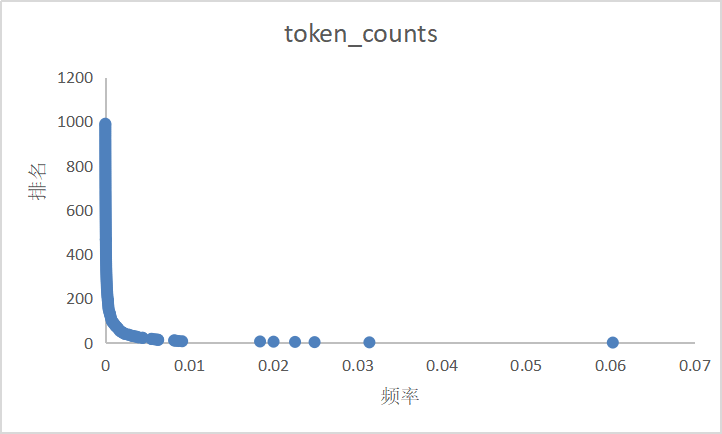
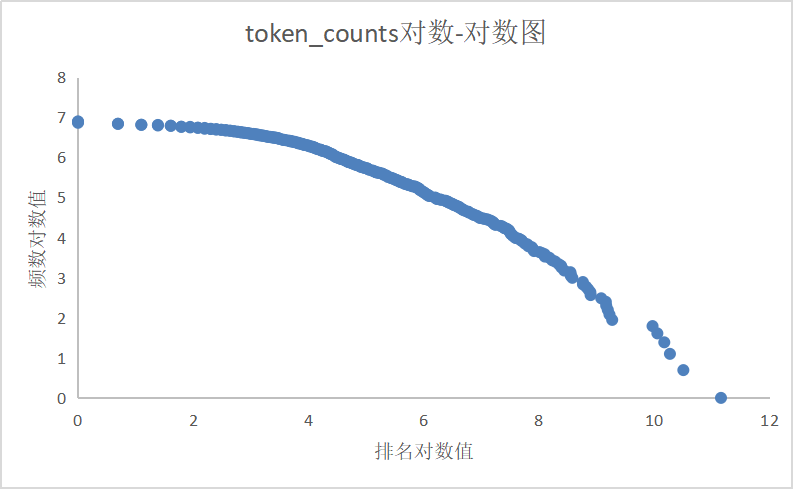
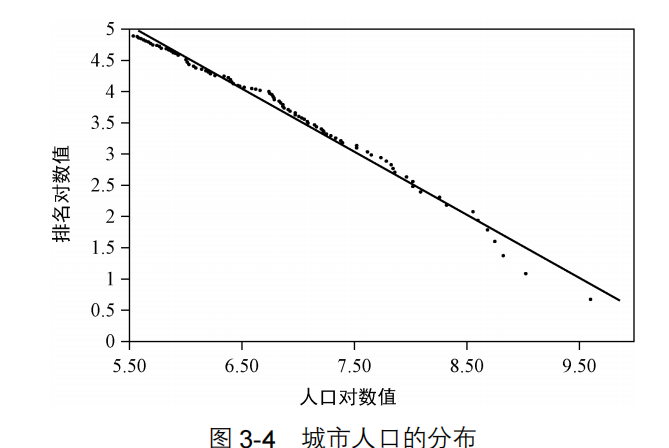

## 主题建模

词计数是有用的，但是纯词计数，即使按照文档的长度进行归一化处理，也不能告诉我们太多该词在当前文档相对于语料库中其他文档的重要度信息。

假设：如果一个词项在某篇文档中出现很多次，但是却很少出现在语料库的其他文档中，那么它对当前文档非常重要。　　　　　　　　　　　　　　　　　　　　
逆文档频率IDF:文档集合中的文档总数除以某个词出现的文档总数。  
逆文档频率（IDF），在齐普夫定律下为主题分析打开了一扇新的窗户。　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　


以维基百科中的“Kite”示例，以该条目下的introduce部分为第一篇文档，history 部分为Kite语料库的第二篇文档：  

    Kites were invented in China, where materials ideal for kite building were readily available: silk fabric for sail material; fine, high-tensile-strength silk for flying line; and resilient bamboo for a strong, lightweight framework.  
    The kite has been claimed as the invention of the 5th-century BC Chinese philosophers Mozi (also Mo Di) and Lu Ban (also Gongshu Ban). By 549 AD paper kites were certainly being flown, as it was recorded that in that year a paper kite was used as a message for a rescue mission. Ancient and medieval Chinese sources describe kites being used for measuring distances, testing the wind, lifting men, signaling, and communication for military operations. The earliest known Chinese kites were flat (not bowed) and often rectangular. Later, tailless kites incorporated a stabilizing bowline. Kites were decorated with mythological motifs and legendary figures; some were fitted with strings and whistles to make musical sounds while flying. From China, kites were introduced to Cambodia, Thailand, India, Japan, Korea and the western world.   
    After its introduction into India, the kite further evolved into the fighter kite, known as the patang in India, where thousands are flown every year on festivals such as Makar Sankranti. Kites were known throughout Polynesia, as far as New Zealand, with the assumption being that the knowledge diffused from China along with the people. Anthropomorphic kites made from cloth and wood were used in religious ceremonies to send prayers to the gods. Polynesian kite traditions are used by anthropologists get an idea of early “primitive” Asian traditions that are believed to have at one time existed in Asia.

In [50]:
>>> from nlpia.data.loaders import kite_text, kite_history 
>>> kite_intro = kite_text.lower() 
>>> intro_tokens = tokenizer.tokenize(kite_intro) 
>>> kite_history = kite_history.lower() 
>>> history_tokens = tokenizer.tokenize(kite_history) 
>>> intro_total = len(intro_tokens) 
>>> print(intro_total) #intro_doc的总词频
>>> history_total = len(history_tokens) 
>>> print(history_total) #history_doc的总词频

363
297


In [183]:
>>> intro_tf = {} 
>>> history_tf = {} 
>>> intro_counts = Counter(intro_tokens) 
>>> intro_tf['kite'] = intro_counts['kite'] / intro_total 
>>> history_counts = Counter(history_tokens) 
>>> history_tf['kite'] = history_counts['kite'] / history_total 
>>> print('Term Frequency of "kite" in intro is: {:.4f}'.format(intro_tf['kite']))
>>> print('Term Frequency of "kite" in history is: {:.4f}'.format(history_tf['kite']))

Term Frequency of "kite" in intro is: 0.0441
Term Frequency of "kite" in history is: 0.0202


就与“kite”的相关度而言，intro部分是否就是 history 部分的两倍呢？进一步挖掘：看看其他一些词如“and”的词项频率

In [186]:
>>> intro_tf['and'] = intro_counts['and'] / intro_total 
>>> history_tf['and'] = history_counts['and'] / history_total 
>>> print('Term Frequency of "and" in intro is: {:.4f}' .format(intro_tf['and'])) 
>>> print('Term Frequency of "and" in history is: {:.4f}'.format(history_tf['and'])) 

Term Frequency of "and" in intro is: 0.0275
Term Frequency of "and" in history is: 0.0303


In [187]:
>>> intro_tf['china'] = intro_counts['china'] / intro_total 
>>> history_tf['china'] = history_counts['china'] / history_total
>>> print('Term Frequency of "china" in intro is: {:.4f}' .format(intro_tf['china'])) 
>>> print('Term Frequency of "china" in history is: {:.4f}'.format(history_tf['china'])) 

Term Frequency of "china" in intro is: 0.0000
Term Frequency of "china" in history is: 0.0101


In [188]:
num_docs_containing_and = 0 
for doc in [intro_tokens, history_tokens]: 
     if 'and' in doc: 
            num_docs_containing_and += 1
num_docs_containing_kite = 0 
for doc in [intro_tokens, history_tokens]: 
     if 'kite' in doc: 
            num_docs_containing_kite += 1
num_docs_containing_china = 0 
for doc in [intro_tokens, history_tokens]: 
     if 'china' in doc: 
            num_docs_containing_china += 1

In [189]:
>>> num_docs = 2 
>>> intro_idf = {}
>>> history_idf = {} 
>>> intro_idf['and'] = num_docs / num_docs_containing_and 
>>> history_idf['and'] = num_docs / num_docs_containing_and 
>>> intro_idf['kite'] = num_docs / num_docs_containing_kite 
>>> history_idf['kite'] = num_docs / num_docs_containing_kite 
>>> intro_idf['china'] = num_docs / num_docs_containing_china 
>>> history_idf['china'] = num_docs / num_docs_containing_china
>>> intro_idf

{'and': 1.0, 'kite': 1.0, 'china': 2.0}

当前示例中的“and”和“kite”，IDF相同：    
 文档总数 / 出现“and”的文档数 = 2/2 = 1；  
 文档总数 / 出现“kite”的文档数 = 2/2 = 1；  
 文档总数 / 出现“China”的文档数 = 2/1 = 2。

In [190]:
>>> intro_tfidf = {} 
>>> intro_tfidf['and'] = intro_tf['and'] * intro_idf['and'] 
>>> intro_tfidf['kite'] = intro_tf['kite'] * intro_idf['kite'] 
>>> intro_tfidf['china'] = intro_tf['china'] * intro_idf['china']
>>> history_tfidf = {} 
>>> history_tfidf['and'] = history_tf['and'] * history_idf['and'] 
>>> history_tfidf['kite'] = history_tf['kite'] * history_idf['kite'] 
>>> history_tfidf['china'] = history_tf['china'] * history_idf['china']
print(intro_tfidf)
print(history_tfidf)

{'and': 0.027548209366391185, 'kite': 0.0440771349862259, 'china': 0.0}
{'and': 0.030303030303030304, 'kite': 0.020202020202020204, 'china': 0.020202020202020204}


有人搜索“cat”这个词，在上述 100 万篇文档中，只有一篇文档包含“cat”。那么这个词的原始或原生IDF 为  
1 000 000 / 1 = 1 000 000   
假设有 10 篇文档包含“dog”，那么“dog”的 IDF 为  
1 000 000 / 10 = 100 000 

齐普夫定律表明，当比较两个词如“cat”和“dog”的词频时，即使它们出现的次数类似，更频繁出现的词的词频也将指数级地高于较不频繁出现的词的词频。因此，齐普夫定律建议使用对数log()来对词频（和文档频率）进行尺度的缩放处理。这就能够确保像“cat”和“dog”这样出现的次数类似的词，在最后的词频计算结果上也不会出现指数级的差异。此外，这种词频的分布将确保 TF-IDF 分数更加符合均匀分布。  

因此，将IDF重新定义为词出现在某篇文档中原始概率的对数。对于词项频率，我们也会进行对数处理。  
现在搜索cst和dog得到的IDF;  
search: cat   
idf = log(1 000 000/1) = 6   
search: dog   
idf = log(1 000 000/10) = 5  

最终，对于语料库 D 中给定的文档 d 里的词项 t，有：  
tf(t, d) = log(t在d中出现的次数/d的长度)  
idf(t, D) = log(文档数/包含t的文档数)  
tfidf(t, d, D) = tf(t, d) × idf(t, D)  
一个词在文档中出现的次数越多，它在文档中的 TF（进而 TF-IDF）就会越高。与此同时，随着包含该词的文档数增加，该词的 IDF（进而 TF-IDF）将下降。 
TF-IDF将特定的词或词条与特定语料库中的特定文档关联起来，然后根据该词在整个语料库中的使用情况，为该词在给定文档中的重要度赋予了一个数值。

In [250]:
term_occurences_in_doc=100
num_terms_in_doc=10000
total_num_docs=1000
num_docs_containing_term=8
log_tf = math.log(term_occurences_in_doc) - math.log(num_terms_in_doc) #某个词项出现在某篇文档中的对数频率
log_idf =math.log(total_num_docs - math.log(num_docs_containing_term)) 
#某个具体词项在文档中至少出现一次的对数概率的对数，前一个对数用于对IDF 线性化（抵消齐普夫定律的影响）
log_tf_idf = log_tf + log_idf #TF-IDF 的对数是词频、IDF 各自求对数后求和
log_tf_idf

2.300503486411899

### 相关度排序

我们也已经了解到，仅仅对词计数并不像使用它们的 TF-IDF 那样具有可描述性。因此，在每个文档向量中，我们用词的 TF-IDF 替换 TF来计算余弦相似度cosΘ=(A·B)/(|A|·|B|)来度量文档的相关性。

In [215]:
#得到语料库中每篇文档TF-IDF的K维向量表示。
document_tfidf_vectors = [] 
for doc in docs: 
    vec = copy.copy(zero_vector) 
    tokens = tokenizer.tokenize(doc.lower()) 
    token_counts = Counter(tokens)  
    for key, value in token_counts.items(): 
        docs_containing_key = 0 
        for _doc in docs: 
            if key in _doc: 
                docs_containing_key += 1 
        tf = value / len(lexicon) 
        if docs_containing_key: 
            idf = len(docs) / docs_containing_key 
        else: 
            idf = 0 
        vec[key] = tf * idf 
    document_tfidf_vectors.append(vec)
document_tfidf_vectors

[OrderedDict([(',', 0.16666666666666666),
              ('.', 0.05555555555555555),
              ('and', 0.08333333333333333),
              ('as', 0),
              ('faster', 0.25),
              ('get', 0.16666666666666666),
              ('got', 0.16666666666666666),
              ('hairy', 0),
              ('harry', 0.0),
              ('home', 0.16666666666666666),
              ('is', 0),
              ('jill', 0),
              ('not', 0),
              ('store', 0.16666666666666666),
              ('than', 0),
              ('the', 0.5),
              ('to', 0.16666666666666666),
              ('would', 0.16666666666666666)]),
 OrderedDict([(',', 0),
              ('.', 0.05555555555555555),
              ('and', 0.08333333333333333),
              ('as', 0),
              ('faster', 0.08333333333333333),
              ('get', 0),
              ('got', 0),
              ('hairy', 0.08333333333333333),
              ('harry', 0.0),
              ('home', 0),
              ('i

关键词搜索：找到与查询语句余弦相似度最高的向量的文档，并将这些文档作为搜索结果返回。

In [235]:
query = "How long does it take to get to the store?" 
query_vec = copy.copy(zero_vector) 
query_vec = copy.copy(zero_vector) 
tokens = tokenizer.tokenize(query.lower()) 
token_counts = Counter(tokens)

for key, value in token_counts.items(): 
    docs_containing_key = 0 
    for _doc in docs: 
        if key in _doc.lower(): 
            docs_containing_key += 1
    if docs_containing_key == 0: 
        continue 
    tf = value / len(tokens) 
    idf = len(docs) / docs_containing_key 
    query_vec[key] = tf * idf

print(docs) #由三篇文档组成的语料库
print(cosine_sim(query_vec, document_tfidf_vectors[0])) #对于当前查询，文档 0 的相关度最高
print(cosine_sim(query_vec, document_tfidf_vectors[1]))
print(cosine_sim(query_vec, document_tfidf_vectors[2]))

['The faster Harry got to the store, the faster and faster Harry would get home.', 'Harry is hairy and faster than Jill.', 'Jill is not as hairy as Harry.']
0.6132857433407973
0.0
0.0


建立聊天机器人：大多数聊天机器人高度依赖搜索引擎，部分聊天机器人完全依赖搜索引擎，将它作为生成回复的唯一算法。  
将简单搜索索引（TF-IDF）转换为聊天机器人：将“问题（即句子）-回复”对形式的训练数据存储起来。然后，就可以使用 TF-IDF 搜索与用户输入的文本最相似的问题（即句子），再返回与该语句关联的回复。

### 矩阵

使用 sklearn 来构建 TF-IDF 矩阵。sklearn TF-IDF类是一个包含.fit()和.transform()方法的模型，这些方法遵循所有机器学习模型的 sklearn API。  
优点：对大规模文本而言，将为我们省去大量工作。

In [237]:
#一个由 3 个文档组成的矩阵，并给出每个词项的逆文档频率（TF-IDF）。
>>> ! pip install scipy 
>>> ! pip install sklearn
>>> from sklearn.feature_extraction.text import TfidfVectorizer 
>>> corpus = docs 
>>> vectorizer = TfidfVectorizer(min_df=1) 
>>> model = vectorizer.fit_transform(corpus) 
>>> print(model.todense().round(2))

[[0.16 0.   0.48 0.21 0.21 0.   0.25 0.21 0.   0.   0.   0.21 0.   0.64
  0.21 0.21]
 [0.37 0.   0.37 0.   0.   0.37 0.29 0.   0.37 0.37 0.   0.   0.49 0.
  0.   0.  ]
 [0.   0.75 0.   0.   0.   0.29 0.22 0.   0.29 0.29 0.38 0.   0.   0.
  0.   0.  ]]


### 其他工具

几十年来，TF-IDF 矩阵（词项-文档矩阵）一直是信息检索的主流。因此，研究人员和企业花费了大量时间来优化IDF部分，以提高搜索结果的相关性。下表列出了一些可以归一化和平滑词项频率权重的方案。

     归一化：归一化方法有两种形式，一种是把数变为（0，1）之间的小数，一种是把有量纲表达式变为无量纲表达式。主要是为了数据处理方便提出来的，把数据映射到0～1范围之内处理，更加便捷快速，应该归到数字信号处理范畴之内。  
    数据平滑：在参数估计中为应对数据稀疏问题而采用的方法。主要思想是将整个概率空间中的一部分概率密度按照一定的策略分配给低频稀疏事件，以使得在稀疏条件下估计出的概率分布更加可靠。
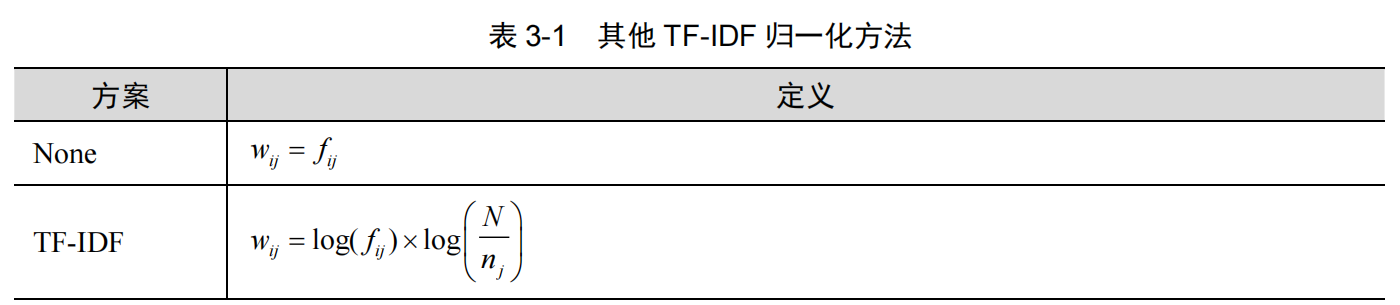
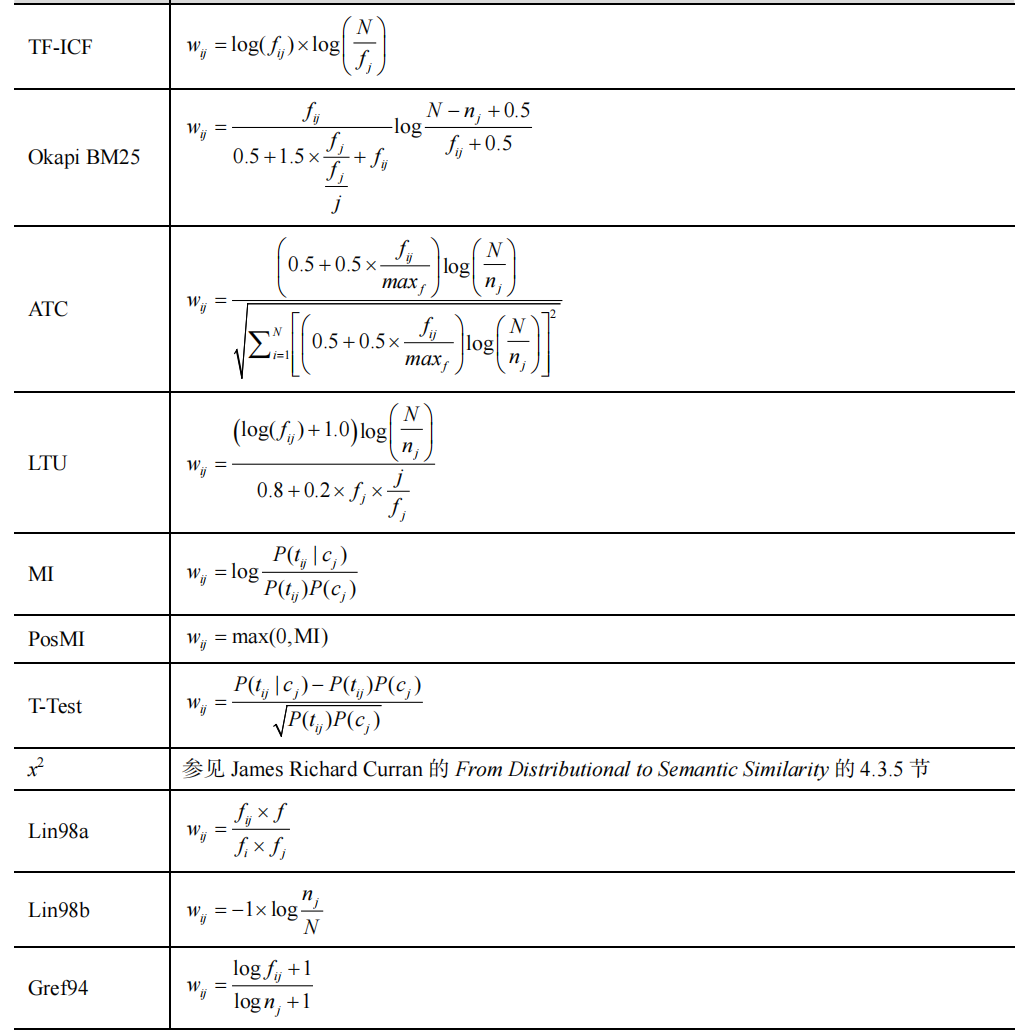

Okapi BM25：  
由伦敦城市大学研究者提出，是更好的给搜索结果排序的方法。  
1.对TF-IDF 余弦相似度进行了归一化和平滑处理；  
2.忽略了查询文档中词项的重复出现，从而有效地将查询向量的词频都简化为 1；  
3.余弦相似度的点积由文档长度本身的一个非线性函数进行归一化计算。

In [23]:
q_idf * dot(q_tf, d_tf[i]) * 1.5 / (dot(q_tf, d_tf[i]) + .25 + .75 * d_num_words[i] / d_num_words.mean())

NameError: name 'q_idf' is not defined

## 小结

１.将整篇文章化为词袋向量，选取合适的指标（TF－IDF）兼顾词项出现频率和信息量；　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
２.奇普夫定律，取对数（ｌｏｇ（TF-IDF））；　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
３.由向量余弦相似度计算语料库中各篇文献的相似性；　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
４.应用：基于文档相似性建立搜索引擎、聊天机器人；　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
５.其他指标。